In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import seaborn as sns
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib.lines import Line2D

In [2]:
gaussian_df = pd.read_csv('https://raw.githubusercontent.com/ggdna/scScaling/main/results/Caltech101_Gaussian.csv')
res_df = pd.read_csv('https://raw.githubusercontent.com/ggdna/scScaling/main/results/Caltech101_resolution.csv')
classes = sorted(gaussian_df[gaussian_df['N instances of label'] > 100]['Class label'].unique())
class_names = ['Faces1', 'Faces2', 'Motorbikes', 'Airplanes', 'Watches', 'All']
gaussian_df['Scale'] = gaussian_df['Scale']**2
res_df['Factor'] = res_df['Factor']

df = pd.read_csv('https://raw.githubusercontent.com/igor-sadalski/Scaling-up-measurement-noise-scaling-laws/main/collect_mi_results.csv')
df.replace('celltype.l3', 'Cell type MI', inplace=True)
df.replace('protein_counts', 'Protein MI', inplace=True)
df.replace('clone', 'Clonal MI', inplace=True)
df.replace('author_day', 'Temporal MI', inplace=True)
df.replace('ng_idx', 'Spatial MI', inplace=True)
df.replace('RandomProjection', 'Rand. Proj.', inplace=True)
# df = df[df['signal'] != 'Cell type MI']

# sc_param_df = pd.read_csv('analysis/final_results/cell_scaling_N0_13906.063_s_1.051_I_inf_1.304.csv')
# sc_param_df = pd.read_csv('analysis/final_results/cell_scaling_N0_21733.759_s_0.502_I_inf_2.927_I_0_0.730.csv')
sc_param_df = pd.read_csv('https://raw.githubusercontent.com/igor-sadalski/Scaling-up-measurement-noise-scaling-laws/main/analysis/final_results/cell_scaling_N0_2328676.073_s_1.100_I_inf_3.141.csv')

sc_param_df.replace('celltype.l3', 'Cell type MI', inplace=True)
sc_param_df.replace('protein_counts', 'Protein MI', inplace=True)
sc_param_df.replace('clone', 'Clonal MI', inplace=True)
sc_param_df.replace('author_day', 'Temporal MI', inplace=True)
sc_param_df.replace('ng_idx', 'Spatial MI', inplace=True)
sc_param_df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

sc_param_df_noise = pd.read_csv('analysis/final_results/scaling_plots_u_bar_138.109_I_max_1.419.csv')
sc_param_df_noise.replace('celltype.l3', 'Cell type MI', inplace=True)
sc_param_df_noise.replace('protein_counts', 'Protein MI', inplace=True)
sc_param_df_noise.replace('clone', 'Clonal MI', inplace=True)
sc_param_df_noise.replace('author_day', 'Temporal MI', inplace=True)
sc_param_df_noise.replace('ng_idx', 'Spatial MI', inplace=True)
sc_param_df_noise.replace('RandomProjection', 'Rand. Proj.', inplace=True)

def cell_number_scaling(x, N0, s, I_inf):
    """
    Cell number scaling function: I(x) = max(I_0, I_inf - (x / N0) ** (-s))
    """
    I_0 = 0
    with np.errstate(divide="ignore", invalid="ignore", over="ignore"):
        # Calculate the scaling term more safely to avoid overflow
        ratio = x / N0
        # Use log-space calculation to avoid overflow
        scaling_term = np.where(
            ratio > 0,
            np.exp(-s * np.log(ratio)),
            0.0
        )
        result = np.where(x > 0, np.maximum(I_0, I_inf - scaling_term), np.nan)
    return result

def info_scaling(u, u_bar, I_max):
    """
    Information scaling function based on:
        I(u) = I_max - 0.5 * log2( (1 + u/u_bar) / (u/u_bar + 2**(-2*I_max)) )
    """
    # Avoid division by zero and invalid values
    u = np.asarray(u)
    u_bar = np.asarray(u_bar)
    I_max = np.asarray(I_max)
    # Set a small epsilon to avoid division by zero
    epsilon = 1e-12
    u_bar_safe = np.where(u_bar == 0, epsilon, u_bar)
    u_over_u_bar = u / u_bar_safe
    numerator = 1 + u_over_u_bar
    denominator = u_over_u_bar + 2 ** (-2 * I_max)
    # Avoid division by zero in denominator
    denominator = np.where(denominator == 0, epsilon, denominator)
    # Avoid negative or zero values inside log2
    ratio = numerator / denominator
    ratio = np.where(ratio <= 0, epsilon, ratio)
    return I_max - 0.5 * np.log2(ratio)

In [3]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'
dpi = 150

In [4]:
c6 = ['#c4bae2','#40ada6','#3c4ebf',
        '#e3a600', '#d6543a', '#edb1a3']
pretty_palette = [c6[c] for c in range(6) if c in [1,2,3,4]]
hue_order = ['Rand. Proj.', 'PCA', 'SCVI', 'Geneformer']

pretty_palette_metrics = ["#C85158",
                    "#62A48F",
                    "#475A7A",
                    "#503A38",
                    "#E9AD97",
                    "#88A4BA",]
hue_order_metrics = ['Protein MI', 'Clonal MI', 'Temporal MI', 'Spatial MI', 'Caltech101-binary']


plotting pre-computed scaling data... go!


/tmp/ipykernel_1349166/101792867.py:49: RuntimeWarning: invalid value encountered in power
  plot_points(ax, N_hat_no_s, (I_inf-y)**(-1/s), color, None, style)


Plotted 54 curves.
plotting pre-computed noise data... go!
Plotted 112 curves.
fitting and plotting for Caltech101-binary...
fitting and plotting for Caltech101-binary...


/tmp/ipykernel_1349166/101792867.py:720: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


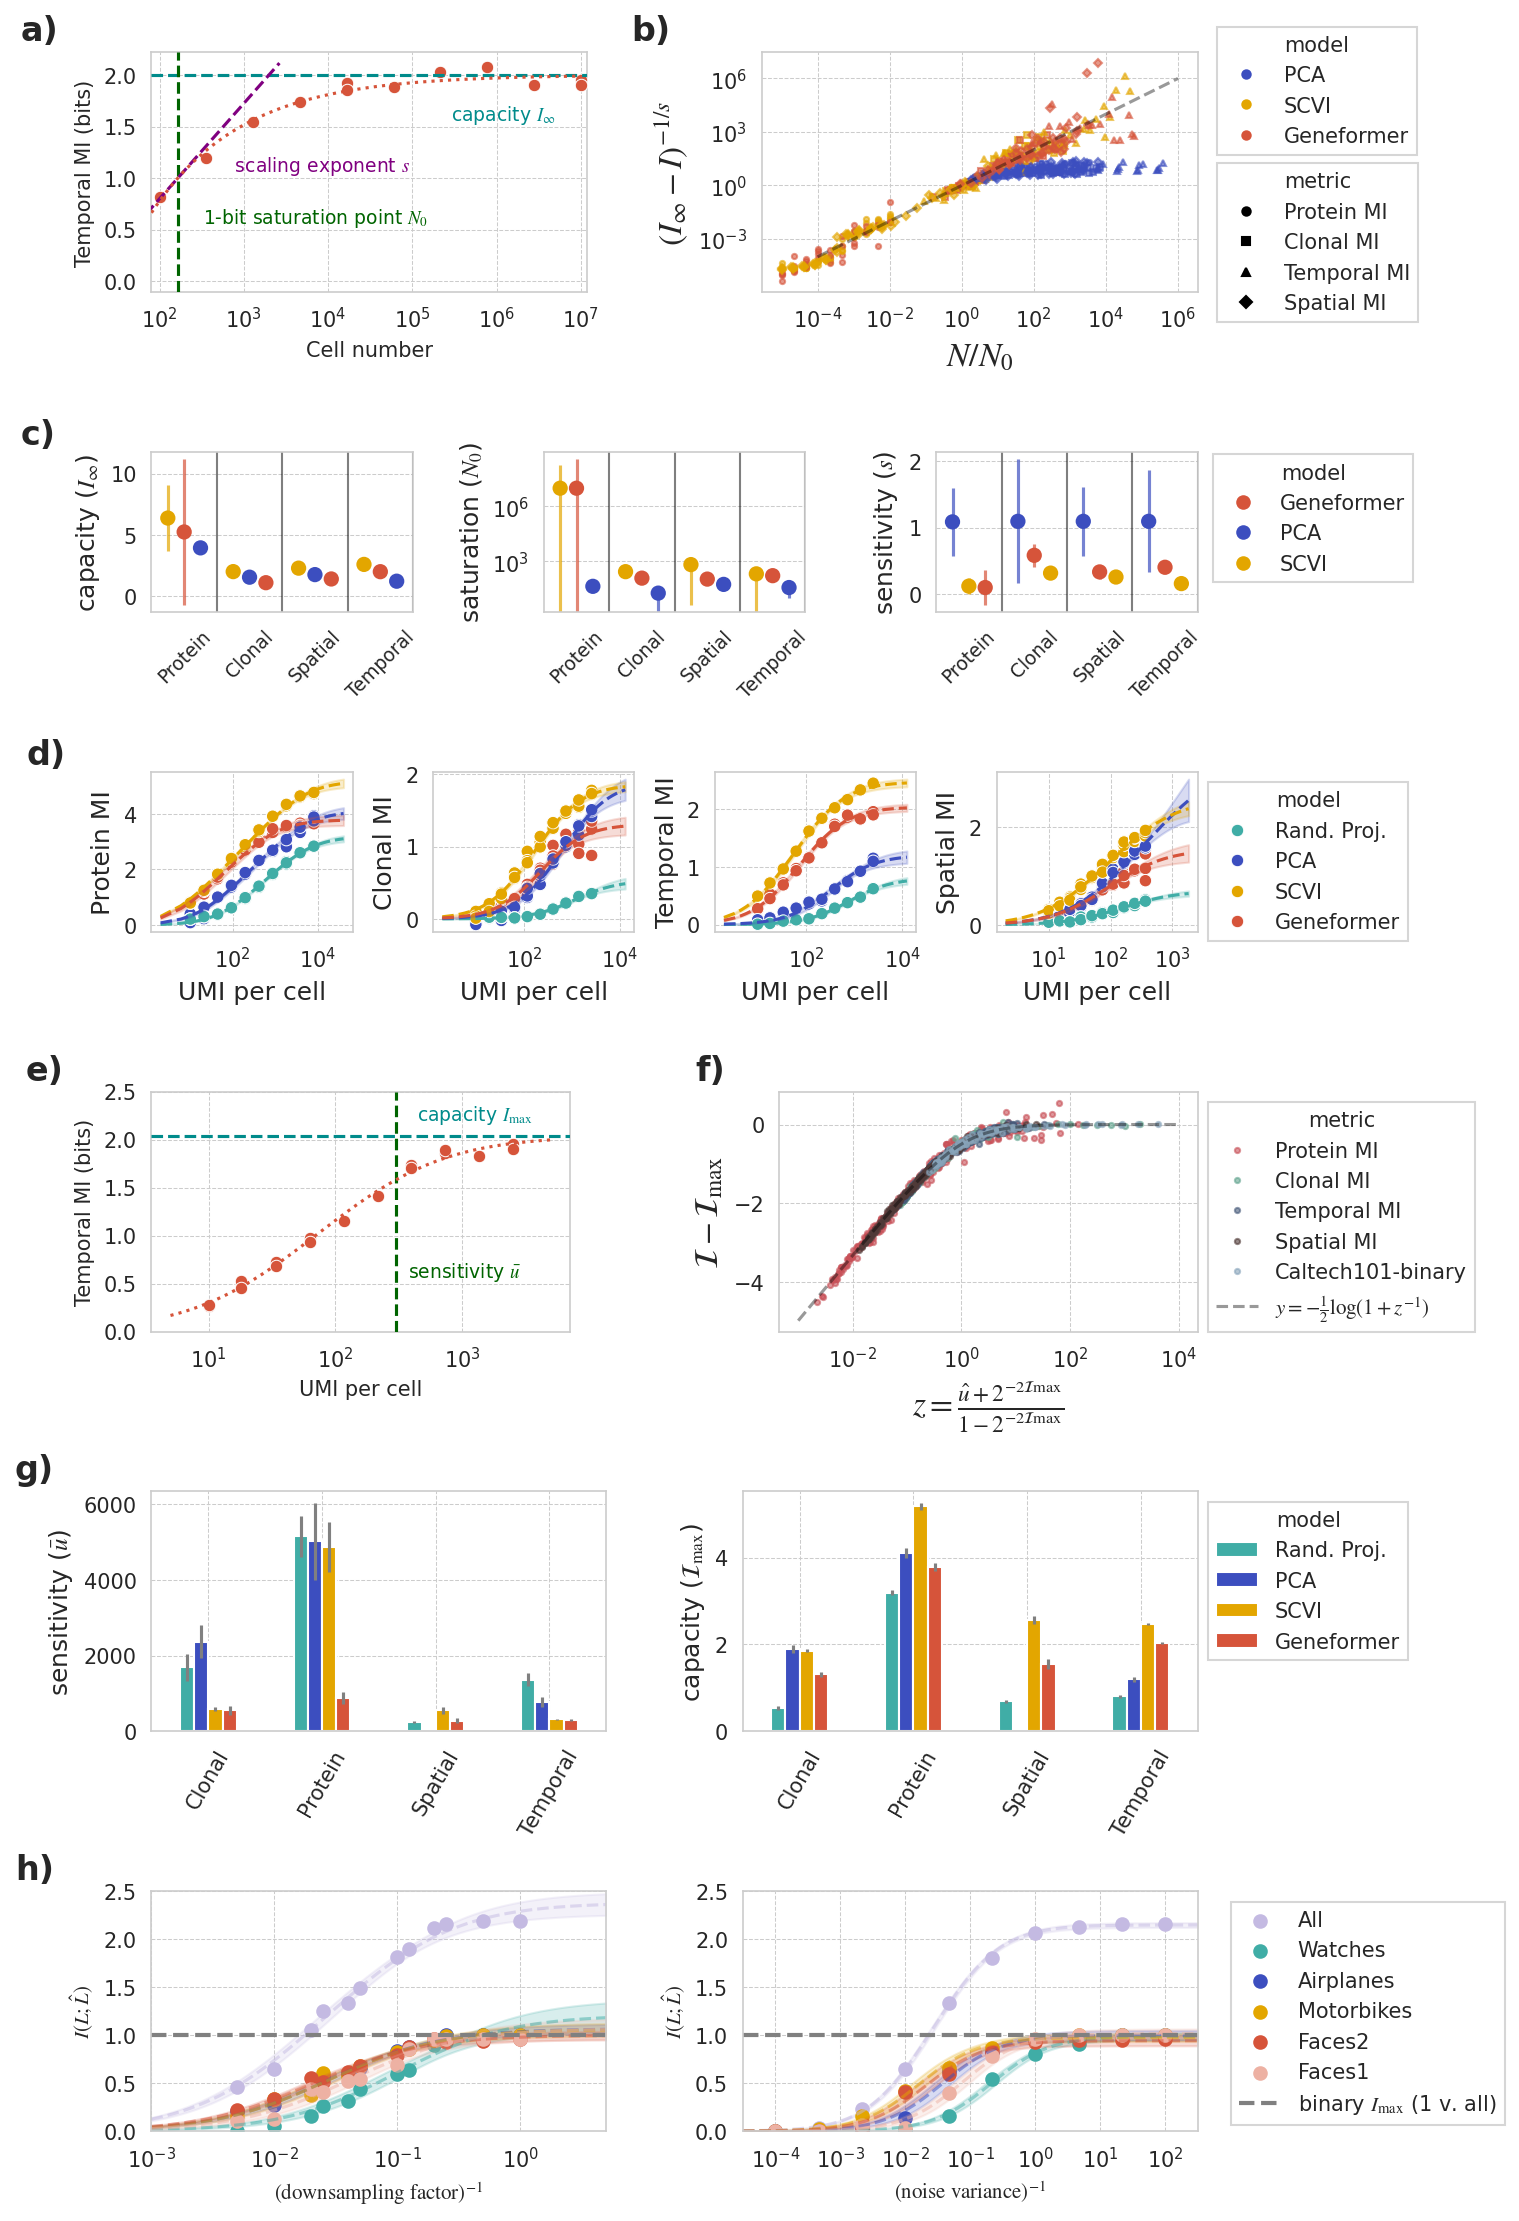

In [5]:
def plot_points(ax, x, y, color, label, marker_style='o'):
    # plot our little points!
    ax.plot(x, y, color=color, marker=marker_style, alpha=0.6, ms=2.5, label=label, lw=0)

def plot_fit(ax, x, y, color):
    """plots a nice fit line"""
    ax.plot(x, y, color=color, linestyle='--', alpha=0.5, lw=0.75, zorder=0.5)

def transform_to_z(x, xbar, imax):
    A = 2**(-2*imax)
    z = ((x/xbar)+A)/(1-A)
    return z

def info_scaling(x, A, B):
    """the info scaling model"""
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

def plot_precomputed_scaling(ax, df, param_df, color_map, marker_map, hue_order_metrics, hue_order_methods):
    """plots data for panel b, the scaling collapse :)"""
    print('plotting pre-computed scaling data... go!')
    
    n_curves = 0
    N_hats = []

    for sig in hue_order_metrics: # metric determines style!
        for q in df['quality'].unique():
            for alg in hue_order_methods: # method determines color!
                data = df[(df['signal'] == sig) & (df['quality'] == q) & (df['algorithm'] == alg)]
                if len(data) < 10: continue
                if q < 0.1: continue

                avg_data = data.groupby('size').mi_value.mean()
                x, y = avg_data.index, avg_data.values

                p = param_df[(param_df['metric'] == sig) & (param_df['method'] == alg) & (param_df['quality'] == q)]
                if p.empty: continue
                
                s = p['s'].values[0]
                N0 = p['N0'].values[0]
                I_inf = p['I_inf'].values[0]

                N_hat = (x/N0)**-s
                N_hat_no_s = (x/N0)

                color = color_map[alg]
                style = marker_map[sig]
                
                # here's the change! no label :)
                plot_points(ax, N_hat_no_s, (I_inf-y)**(-1/s), color, None, style)
                
                if len(y) > 0:
                    n_curves += 1
                N_hats.append(N_hat_no_s)

                if np.min(N_hat) < 10**-5:
                    print(f'Warning: N_hat << 1 for {sig}, {alg}, quality {q}')
    print(f'Plotted {n_curves} curves.')


def plot_precomputed_noise(ax, df, param_df, palette, plot_fits=False):
    """plots data for panel e, the noise collapse!"""
    print('plotting pre-computed noise data... go!')
    hue_order = ['PCA', 'SCVI', 'Geneformer']

    # loop through all our datasets
    n_curves = 0
    for idx, sig in enumerate(hue_order_metrics):
        for size in df['size'].unique():
            for alg in hue_order:
                # grab the right chunk of data
                data = df[(df['signal'] == sig) & (df['size'] == size) & (df['algorithm'] == alg)]
                if len(data) < 10: continue

                avg_data = data.groupby('umis_per_cell').mi_value.mean()
                x, y = avg_data.index, avg_data.values

                # find the magic parameters!
                p = param_df[(param_df['metric'] == sig) & (param_df['method'] == alg) & (param_df['size'] == size)]
                if p.empty: continue
                
                xbar, imax = p['fitted_u_bar'].values[0], p['fitted_I_max'].values[0]
                xbar_err, imax_err = p['u_bar_error'].values[0], p['I_max_error'].values[0]

                # skip if errors are wonky
                if not (xbar_err < xbar and imax_err < imax): continue

                # normalize and plot!
                z = transform_to_z(x, xbar, imax)
                plot_points(ax, z, y-imax, palette[idx], sig)
                n_curves += 1
    print(f'Plotted {n_curves} curves.')

def fit_and_plot(ax, df, x_col, color, label, plot_fits=False):
    """fits the model on the fly and plots the results."""
    print(f'fitting and plotting for {label}...')

    for class_label in df['Class label'].unique()[:-1]:
        data = df[df['Class label'] == class_label]
        x_data, y_data = 1 / data[x_col], data['MI']

        # set up and run the model fit
        model = Model(info_scaling)
        params = model.make_params(a=1e-2, b=1e-2)
        params['A'].min = 0
        params['B'].min = 0
        result = model.fit(y_data, params, x=x_data)
        
        # check if the fit is reasonable
        a, b = result.params['A'], result.params['B']
        if a.stderr is not None and b.stderr is not None and a.stderr < a.value and b.stderr < b.value:
            x_bar = 1 / a.value
            i_max = 0.5 * np.log2(b.value / a.value)

            # normalize and plot!
            z = transform_to_z(x_data, x_bar, i_max)
            plot_points(ax, z, y_data - i_max, color, label)


# global style setup
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['grid.linestyle'] = 'dashed'
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['text.usetex'] = True
dpi = 150
# mpl.rcParams['font.family'] = 'serif' # or 'sans-serif' or 'monospace'
# mpl.rcParams['font.serif'] = 'cmr10'
# mpl.rcParams['font.sans-serif'] = 'cmss10'
# mpl.rcParams['font.monospace'] = 'cmtt10'
# mpl.rcParams["axes.formatter.use_mathtext"] = True
# mpl.rcParams['text.latex.preamble'] = r'\boldmath'
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["svg.fonttype"] = 'none'

# create the main figure and the master gridspec
# 6 rows, with heights 3, 2, 2, 3, 3, 3
fig = plt.figure(figsize=(9, 18), dpi=dpi)
gs_main = fig.add_gridspec(6, 1, height_ratios=[3, 2, 2, 3, 3, 3], hspace=0.75)


# ---
# panel a & b (row 1: 1x2 grid)
# ---
gs_row1 = gs_main[0].subgridspec(1, 2, wspace=0.4)

# panel a: scaling example
ax_scaling_example = fig.add_subplot(gs_row1[0])
metric = 'Temporal MI'
for method in ['Geneformer']:
    subset = sc_param_df[(sc_param_df['quality'] == 1) &
                         (sc_param_df['method'] == method) &
                         (sc_param_df['metric'] == metric)]
        
    s = subset['s'].values[0]
    N0 = subset['N0'].values[0]
    I_inf = subset['I_inf'].values[0]

    data = df[(df['quality'] == 1) &
              (df['algorithm'] == method) &
              (df['signal'] == metric)]
    
    sns.scatterplot(
        data=data,
        x='size',
        y=data['mi_value'].values,
        color=pretty_palette[hue_order.index(method)],
        label=method,
        legend=False,
        ax=ax_scaling_example,
        zorder=3 # make sure scatter is on top!
    )
    xs = np.logspace(1, 7, 100)
    ys = I_inf - (xs / N0) ** -s
    ys = np.maximum(ys, 0)
    ax_scaling_example.plot(xs, ys, linestyle=':', color=pretty_palette[hue_order.index(method)], zorder=20)
    
    # annotation
    
    anno_zorder=10
    anno_style = 'dashed'
    anno_lw = 1.5

    # I_inf
    I_inf_color = 'darkcyan'
    ax_scaling_example.axhline(I_inf, linestyle=anno_style, color=I_inf_color, zorder=anno_zorder, lw=anno_lw)
    ax_scaling_example.text(
        data['size'].max()/2, I_inf-0.5, # position at right edge
        f'capacity $I_\\infty$', 
        ha='right', va='bottom', # text above the line
        color=I_inf_color, fontsize=9
    )
    
    # N0
    N0_color = 'darkgreen'
    ax_scaling_example.axvline(N0, linestyle=anno_style, color=N0_color, zorder=anno_zorder, lw=anno_lw)
    ax_scaling_example.text(
        N0*2, 0.5, # position at bottom edge
        f'1-bit saturation point $N_0$', 
        ha='left', va='bottom', # text below the line
        color=N0_color, fontsize=9
    )
    
    # s
    s_color = 'purple'
    # the tangent point is (N0, I_inf - 1)
    y_tangent = I_inf - 1
    
    x_tan_1 = N0 / 8
    x_tan_2 = N0 * 16
    
    # we need np.log (base e) for this!
    y_tan_1 = s * np.log(x_tan_1) - s * np.log(N0) + y_tangent
    y_tan_2 = s * np.log(x_tan_2) - s * np.log(N0) + y_tangent
    
    ax_scaling_example.plot([x_tan_1, x_tan_2], [y_tan_1, y_tan_2], linestyle=anno_style, color=s_color, zorder=anno_zorder, lw=anno_lw)
    ax_scaling_example.text(
        x_tan_2/4, y_tan_2-1,
        f' scaling exponent $s$', 
        ha='left', va='center',
        color=s_color, fontsize=9
    )
    
ax_scaling_example.set_xscale('log')
ax_scaling_example.set_xlabel('Cell number')
ax_scaling_example.set_ylabel('Temporal MI (bits)')
ax_scaling_example.set_xlim(data['size'].min()*0.8, data['size'].max()*1.2)

# panel b: scaling collapse
ax_scaling_collapse = fig.add_subplot(gs_row1[1])

hue_order_methods = ['PCA', 'SCVI', 'Geneformer'] 
markers = ['o', 's', '^', 'D', 'v'] # our marker styles

color_map = {method: pretty_palette[i+1] for i, method in enumerate(hue_order_methods)}
marker_map = {metric: markers[i % len(markers)] for i, metric in enumerate(hue_order_metrics) if metric != 'Caltech101-binary'}

plot_precomputed_scaling(ax_scaling_collapse, df, sc_param_df, color_map, marker_map, hue_order_metrics, hue_order_methods)

# theory curve
xs = np.logspace(-4, 6, 100)
ax_scaling_collapse.plot(xs, xs, color='black', linestyle='--', alpha=0.4, lw=1.5,
         label=r'$y = x$',zorder=10)

ax_scaling_collapse.set_xscale('log')
ax_scaling_collapse.set_yscale('log')
ax_scaling_collapse.set_xlabel(r'$N/N_0$', fontsize=16)
ax_scaling_collapse.set_ylabel(r'$(I_{\infty} - I)^{-1/s}$', fontsize=16)

method_handles = [Line2D([0], [0], color=color_map[method], marker='o', linestyle='None',
                         label=method, ms=4) for method in hue_order_methods]
leg1 = ax_scaling_collapse.legend(handles=method_handles, loc='upper left', 
                   bbox_to_anchor=(1.02, 1.15), title='model')
metric_handles = [Line2D([0], [0], color='black', marker=marker_map[metric], linestyle='None',
                         label=metric, ms=4) for metric in hue_order_metrics if metric != 'Caltech101-binary']
leg2 = ax_scaling_collapse.legend(handles=metric_handles, loc='upper left',
                   bbox_to_anchor=(1.02, 0.58), title='metric')
ax_scaling_collapse.add_artist(leg1)


# ---
# panel c (row 2: 1x3 grid)
# ---
gs_row2 = gs_main[1].subgridspec(1, 3, wspace=0.5)
axs_param_strips = [fig.add_subplot(gs_row2[i]) for i in range(3)]

sc_param_df['min I'] = [df[(df['signal'] == metric) & (df['quality'] == 1) 
                           & (df['algorithm'] == method)]['mi_value'].min() 
                           for metric, method in zip(sc_param_df['metric'].values, sc_param_df['method'].values)]

color_dict = {
    "Geneformer": pretty_palette[3],
    "PCA": pretty_palette[1],
    "SCVI": pretty_palette[2],
}

method_order = ["Geneformer", "PCA", "SCVI"]
x_count = 0
all_labels = []
center_positions = []
metric_labels = []

for metric in sc_param_df['metric'].unique():
    if metric == 'Cell type MI':
        continue
    subset = sc_param_df[(sc_param_df['quality'] == 1) &
                         (sc_param_df['metric'] == metric)].copy()
    
    subset['I_inf - min I'] = subset['I_inf'] - subset['min I']
    subset = subset[subset['I_inf - min I'] > 0.2]
    subset = subset[subset['mean_residual'] < 0.75]
    cell_number_min = df[(df['signal'] == metric)]['size'].min()
    subset = subset[~subset['method'].isin(['Rand. Proj.'])]
    
    if subset.empty:
        continue

    n = len(subset)
    positions = x_count + np.arange(n)
    group_center = x_count + (n - 1) / 2.0
    center_positions.append(group_center)
    metric_labels.append(metric)
    marker_size = 40

    # scatter in each panel
    
    # sensitivity (s)
    subset = subset.sort_values(by='s', ascending=False)
    colors = [color_dict.get(m, 'black') for m in subset['method']] # helper var!
    axs_param_strips[2].scatter(positions, subset['s'],
                   color=colors,
                   zorder=3, s=marker_size)
    axs_param_strips[2].errorbar(positions, subset['s'], yerr=subset['s_error'],
                   fmt='none', ecolor=colors, zorder=2, alpha=0.7) # added bars!

    # capacity (i_inf)
    subset = subset.sort_values(by='I_inf', ascending=False)
    colors = [color_dict.get(m, 'black') for m in subset['method']] # need to remake colors after sort
    axs_param_strips[0].scatter(positions, subset['I_inf'],
                   color=colors,
                   zorder=3, s=marker_size)
    axs_param_strips[0].errorbar(positions, subset['I_inf'], yerr=subset['I_inf_error'],
                   fmt='none', ecolor=colors, zorder=2, alpha=0.7) # more bars! :)

    # saturation (n0)
    subset = subset.sort_values(by='N0', ascending=False)
    colors = [color_dict.get(m, 'black') for m in subset['method']] # one last time
    axs_param_strips[1].scatter(positions, subset['N0'],
                   color=colors,
                   zorder=3, s=marker_size)
    axs_param_strips[1].errorbar(positions, subset['N0'], yerr=subset['N0_error'],
                   fmt='none', ecolor=colors, zorder=2, alpha=0.7) # and done!

    # vertical separator
    sep_x = x_count + n
    for ax in axs_param_strips:
        ax.axvline(x=sep_x, color='black', linestyle='-', alpha=0.5, lw=1)

    all_labels.extend(list(subset['method'] + ' - ' + subset['metric']))
    x_count += n + 1

if len(center_positions) > 0:
    for i, ax in enumerate(axs_param_strips):
        ax.set_xticks(center_positions)
        ax.set_xticklabels([m[:-3] for m in metric_labels], rotation=45, ha='center', fontsize=9)
        ax.set_xlim(-1, x_count - 1)
        ax.yaxis.grid(True)
        ax.xaxis.grid(False)

axs_param_strips[2].set_ylabel(r'sensitivity ($s$)', fontsize=12)
# axs_param_strips[2].set_ylim(0, 1.2)
axs_param_strips[0].set_ylabel(r'capacity ($I_{\infty}$)', fontsize=12)
# axs_param_strips[0].set_ylim(0, 5.5)
axs_param_strips[1].set_ylabel(r'saturation ($N_{0}$)', fontsize=12)
axs_param_strips[1].set_yscale('log')
# axs_param_strips[1].set_ylim(10**-1, 10**6.5)

axs_param_strips[2].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=m,
                                  markersize=8, markerfacecolor=color_dict[m])
                   for m in method_order if m in color_dict],
               title='model', fontsize='10',
               bbox_to_anchor=(1.02, 1.05), loc='upper left')


# ---
# panel d (row 3: 1x4 grid)
# ---
gs_row3 = gs_main[2].subgridspec(1, 4, wspace=0.4)
axs_noise_examples = [fig.add_subplot(gs_row3[i]) for i in range(4)]

# plot each signal on its own ax
for ax, sig, color in zip(axs_noise_examples, hue_order_metrics, pretty_palette):
    sub = df[df['signal'] == sig]
    max_sub = sub[sub['size'] == sub['size'].max()] # pick largest dataset

    # scatter raw values
    sns.scatterplot(
        data=max_sub,
        x='umis_per_cell', y='mi_value',
        hue='algorithm', palette=pretty_palette,
        hue_order=hue_order,
        ax=ax,
        legend=ax==axs_noise_examples[-1] # only legend on the last one!
    )

    # fit & plot model curves + conf bands
    for i, alg in enumerate(hue_order):
        dat = max_sub[max_sub['algorithm'] == alg]
        x = dat['umis_per_cell']
        y = dat['mi_value']

        m = Model(info_scaling)
        params = m.make_params(A=1e-1, B=1e-2)
        params['A'].min = params['B'].min = 0

        if len(y) < 9:
            continue
        res = m.fit(y, params, x=x)

        # smooth fit line
        x_fit = np.linspace(x.min()/5, x.max()*5, 10_000)
        y_fit = m.eval(params=res.params, x=x_fit)

        # 95% conf band
        y_err = res.eval_uncertainty(params=res.params, x=x_fit, sigma=2)
        ax.fill_between(x_fit, y_fit + y_err, y_fit - y_err,
                        color=pretty_palette[i], alpha=0.2)
        ax.plot(x_fit, y_fit, color=pretty_palette[i], linestyle='--')

    ax.set_xscale('log')
    ax.set_ylabel(sig, fontsize=12)
    ax.set_xlabel('UMI per cell', fontsize=12)
    
# move legend
sns.move_legend(
    axs_noise_examples[-1], 'upper left',
    bbox_to_anchor=(1, 1), title='model'
)


# ---
# panel e & f (row 4: 1x2 grid)
# ---

# add subplot with space 1 on both right and left sides
gs_row4 = gs_main[3].subgridspec(1, 2, width_ratios=[4, 4], wspace=0.5)

# panel e: noise example
ax_noise_annotation = fig.add_subplot(gs_row4[0])
metric = 'Temporal MI'
for method in ['Geneformer']:
    max_cell_number = df[(df['signal'] == metric)]['size'].max()

    subset = sc_param_df_noise[(sc_param_df_noise['size'] == max_cell_number) &
                         (sc_param_df_noise['method'] == method) &
                         (sc_param_df_noise['metric'] == metric)]
        
    u_bar = subset['fitted_u_bar'].values[0]
    I_max = subset['fitted_I_max'].values[0]


    data = df[(df['size'] == max_cell_number) &
              (df['algorithm'] == method) &
              (df['signal'] == metric)]
    
    sns.scatterplot(
        data=data,
        x='umis_per_cell',
        y=data['mi_value'].values,
        color=pretty_palette[hue_order.index(method)],
        label=method,
        legend=False,
        ax=ax_noise_annotation,
        zorder=3 # make sure scatter is on top!
    )
    xs = np.logspace(np.log10(data['umis_per_cell'].min()/2), np.log10(data['umis_per_cell'].max()*2), 100)
    ys = I_max - 0.5 * np.log2((1 + xs / u_bar) / (xs / u_bar + 2**(-2 * I_max)))
    ys = np.maximum(ys, 0)
    ax_noise_annotation.plot(xs, ys, linestyle=':', color=pretty_palette[hue_order.index(method)], zorder=20)
    
    # annotation
    
    anno_zorder=10
    anno_style = 'dashed'
    anno_lw = 1.5

    # I max
    I_max_color = 'darkcyan'
    ax_noise_annotation.axhline(I_max, linestyle=anno_style, color=I_max_color, zorder=anno_zorder, lw=anno_lw)
    ax_noise_annotation.text(
        data['umis_per_cell'].max()/2, I_max+0.1, # position at right edge
        f'capacity $I_\\max$', 
        ha='center', va='bottom', # text above the line
        color=I_max_color, fontsize=9
    )

    # ubar
    u_bar_color = 'darkgreen'
    ax_noise_annotation.axvline(u_bar, linestyle=anno_style, color=u_bar_color, zorder=anno_zorder, lw=anno_lw)
    ax_noise_annotation.text(
        u_bar*1.25, 0.5, # position at bottom edge
        f'sensitivity $\\bar{{u}}$', 
        ha='left', va='bottom',
        color=u_bar_color, fontsize=9
    )
ax_noise_annotation.set_xscale('log')
ax_noise_annotation.set_ylim(0, 2.5)
ax_noise_annotation.set_xlabel('UMI per cell')
ax_noise_annotation.set_ylabel('Temporal MI (bits)')

# panel f: noise collapse
ax_noise_collapse = fig.add_subplot(gs_row4[1])

show_fits = False
plot_precomputed_noise(ax_noise_collapse, df, sc_param_df_noise, pretty_palette_metrics, show_fits)
fit_and_plot(ax_noise_collapse, gaussian_df, 'Scale', pretty_palette_metrics[-1], 'Caltech101-binary', show_fits)
fit_and_plot(ax_noise_collapse, res_df, 'Factor', pretty_palette_metrics[-1], 'Caltech101-binary', show_fits)

# theory curve
xs = np.logspace(-3, 4, 100)
ax_noise_collapse.plot(xs, -np.log2((1+xs)/xs)/2, color='black', linestyle='--', alpha=0.4, lw=1.5,
         label=r'$y = -\frac{1}{2}\log(1 + z^{-1})$',zorder=10)

ax_noise_collapse.set_xscale('log')
ax_noise_collapse.set_ylabel(r'$\mathcal{I} - \mathcal{I}_{\max}$', fontsize=16)
ax_noise_collapse.set_xlabel(r'$z = \frac{\hat{u} + 2^{-2\mathcal{I}{\max}}}{1 - 2^{-2\mathcal{I}{\max}}}$', fontsize=16)

# handle the legend!
handles, labels = ax_noise_collapse.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_noise_collapse.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1.0, 1.), title='metric')


# ---
# panel g (row 5: 1x2 grid)
# ---
gs_row5 = gs_main[4].subgridspec(1, 2, wspace=0.3)
axs_noise_params_bar = [fig.add_subplot(gs_row5[i]) for i in range(2)]

noise_df = pd.read_csv('analysis/final_results/scaling_plots_u_bar_138.109_I_max_1.419.csv')
noise_df = noise_df[noise_df['I_max_error'] < 0.5]
noise_df = noise_df[noise_df['metric'] != 'celltype.l3']
noise_df = noise_df[noise_df['size'].isin(noise_df.groupby('dataset')['size'].max().values)]
noise_df.replace('protein_counts', 'Protein', inplace=True)
noise_df.replace('clone', 'Clonal', inplace=True)
noise_df.replace('author_day', 'Temporal', inplace=True)
noise_df.replace('ng_idx', 'Spatial', inplace=True)
noise_df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

# plot 1
means = noise_df.pivot(index='metric', columns='method', values='fitted_u_bar')
errors = noise_df.pivot(index='metric', columns='method', values='u_bar_error')
means[hue_order].plot(kind='bar', yerr=errors, ax=axs_noise_params_bar[0],
                      color=pretty_palette, capsize=0, ecolor='grey',
                      capstyle='round', rot=0, legend=False)               
axs_noise_params_bar[0].set_xlabel('')
axs_noise_params_bar[0].set_ylabel(r'sensitivity ($\bar{u}$)', fontsize=12)
axs_noise_params_bar[0].tick_params(axis='x', rotation=60)

# plot 2
means = noise_df.pivot(index='metric', columns='method', values='fitted_I_max')
errors = noise_df.pivot(index='metric', columns='method', values='I_max_error')
means[hue_order].plot(kind='bar', yerr=errors, ax=axs_noise_params_bar[1],
                      color=pretty_palette, capsize=0, ecolor='grey',
                      capstyle='round', rot=0)               
axs_noise_params_bar[1].set_xlabel('')
axs_noise_params_bar[1].set_ylabel(r'capacity ($\mathcal{I}_{\max}$)', fontsize=12)
axs_noise_params_bar[1].legend(title='model', bbox_to_anchor=(1.0, 1), loc='upper left')
axs_noise_params_bar[1].tick_params(axis='x', rotation=60)

# # pivot data for both plots first!
# # plot 1 data
# means_0 = noise_df.pivot(index='metric', columns='method', values='fitted_u_bar')
# errors_0 = noise_df.pivot(index='metric', columns='method', values='u_bar_error')

# # plot 2 data
# means_1 = noise_df.pivot(index='metric', columns='method', values='fitted_I_max')
# errors_1 = noise_df.pivot(index='metric', columns='method', values='I_max_error')

# # assuming hue_order and pretty_palette are defined...
# # we need a color dict like before!
# color_dict = {method: color for method, color in zip(hue_order, pretty_palette)}

# x_count = 0
# center_positions = []
# metric_labels = []

# # get metrics from the index of our new pivoted df
# metrics = means_0.index

# for metric in metrics:
#     # how many dots in this group?
#     n = len(hue_order)
    
#     # calculate x positions
#     positions = x_count + np.arange(n)
#     group_center = x_count + (n - 1) / 2.0
#     center_positions.append(group_center)
#     metric_labels.append(metric)

#     # get values for this group
#     y_vals_0 = means_0.loc[metric, hue_order]
#     y_errs_0 = errors_0.loc[metric, hue_order]
#     y_vals_1 = means_1.loc[metric, hue_order]
#     y_errs_1 = errors_1.loc[metric, hue_order]
    
#     # get colors for this group
#     colors = [color_dict.get(m, 'black') for m in hue_order]

#     # --- plot 1 (sensitivity) ---
#     axs_noise_params_bar[0].scatter(positions, y_vals_0, color=colors, zorder=3, s=40)
#     axs_noise_params_bar[0].errorbar(positions, y_vals_0, yerr=y_errs_0,
#                    fmt='none', ecolor=colors, zorder=2, alpha=0.7)

#     # --- plot 2 (capacity) ---
#     axs_noise_params_bar[1].scatter(positions, y_vals_1, color=colors, zorder=3, s=40)
#     axs_noise_params_bar[1].errorbar(positions, y_vals_1, yerr=y_errs_1,
#                    fmt='none', ecolor=colors, zorder=2, alpha=0.7)

#     # vertical separator
#     sep_x = x_count + n
#     for ax in axs_noise_params_bar:
#         ax.axvline(x=sep_x, color='black', linestyle='-', alpha=0.5, lw=1)

#     x_count += n + 1 # add a little gap!

# # x-axis ticks and labels
# for ax in axs_noise_params_bar:
#     ax.set_xticks(center_positions)
#     # use the 60 deg rotation from your original tick_params
#     ax.set_xticklabels(metric_labels, rotation=60, ha='center', fontsize=9) 
#     ax.set_xlim(-1, x_count - 1)
#     ax.yaxis.grid(True)
#     ax.xaxis.grid(False)
#     ax.set_xlabel('')

# # y-labels
# axs_noise_params_bar[0].set_ylabel(r'sensitivity ($\bar{u}$)', fontsize=12)
# axs_noise_params_bar[1].set_ylabel(r'capacity ($\mathcal{I}_{\max}$)', fontsize=12)

# # custom legend (like in axs_param_strips)
# legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=m,
#                               markersize=8, markerfacecolor=color_dict[m])
#                    for m in hue_order if m in color_dict]

# # add legend to the second plot, just like your bar chart
# axs_noise_params_bar[1].legend(handles=legend_handles,
#                title='model',
#                bbox_to_anchor=(1.0, 1), loc='upper left')


# ---
# panel h (row 6: 1x2 grid)
# ---
gs_row6 = gs_main[5].subgridspec(1, 2, wspace=0.3)
axs_caltech = [fig.add_subplot(gs_row6[i]) for i in range(2)]

# plot 1
pdf = res_df
classes = sorted(pdf[pdf['N instances of label'] > 100]['Class label'].unique())
class_names = ['Faces1', 'Faces2', 'Motorbikes', 'Airplanes', 'Watches', 'All']
palette = c6

for i, x in enumerate(classes[::-1]):
    x_data = (1 / (pdf[pdf['Class label'] == x]['Factor']))
    y_data = pdf[pdf['Class label'] == x]['MI']

    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)
    params['A'].min = 0
    params['B'].min = 0
    result = model.fit(y_data, params, x=x_data)

    x_fit = np.linspace(x_data.min()/5, 5*x_data.max(), 10**5)
    y_fit = model.eval(params=result.params, x=x_fit)
    y_err = result.eval_uncertainty(params=result.params, x=x_fit, sigma=2)

    axs_caltech[0].plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
    axs_caltech[0].fill_between(x_fit, y_fit + y_err, y_fit - y_err, color=palette[i], alpha=0.2)
    axs_caltech[0].scatter(x_data, y_data, color=palette[i], label=class_names[::-1][i])

p0_xmin = np.min(x_fit)
p0_xmax = np.max(x_fit)
axs_caltech[0].plot([np.min(x_fit), np.max(x_fit)], [1, 1], linestyle='dashed', 
         color='grey', label=r'$\log(2)$', lw=2)
axs_caltech[0].set_xlabel(r'$\text{(downsampling factor)}^{-1}$')
axs_caltech[0].set_ylabel(r'$I(L; \hat{L})$')
axs_caltech[0].set_xscale('log')

# plot 2
pdf = gaussian_df
classes = sorted(pdf[pdf['N instances of label'] > 100]['Class label'].unique())
class_names = ['Faces1', 'Faces2', 'Motorbikes', 'Airplanes', 'Watches', 'All']
palette = c6

for i, x in enumerate(classes[::-1]):
    x_data = (1 / (pdf[pdf['Class label'] == x]['Scale']))
    y_data = pdf[pdf['Class label'] == x]['MI']

    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)
    params['A'].min = 0
    params['B'].min = 0
    result = model.fit(y_data, params, x=x_data)

    x_fit = np.logspace(-4.5, 2.5, 10**5)
    y_fit = model.eval(params=result.params, x=x_fit)
    y_err = result.eval_uncertainty(params=result.params, x=x_fit, sigma=2)

    axs_caltech[1].plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
    axs_caltech[1].fill_between(x_fit, y_fit + y_err, y_fit - y_err, color=palette[i], alpha=0.2)
    axs_caltech[1].scatter(x_data, y_data, color=palette[i], label=class_names[::-1][i])

axs_caltech[1].plot([10**-4.5, 10**2.5], [1, 1], linestyle='dashed', 
         color='grey', label=r'binary $I_{\max}$ (1 v. all)', lw=2)
axs_caltech[1].set_xlabel(r'$\text{(noise variance)}^{-1}$')
axs_caltech[1].set_ylabel(r'$I(L; \hat{L})$')
axs_caltech[1].set_xscale('log')
axs_caltech[1].legend(loc='upper left', bbox_to_anchor = (1.05, 1))

axs_caltech[0].set_xlim(p0_xmin, p0_xmax)
axs_caltech[1].set_xlim(10**-4.5, 10**2.5)
axs_caltech[1].set_ylim(0, 2.5)
axs_caltech[0].set_ylim(0, 2.5)


ax_scaling_example.text(-0.3, 1.05, 'a)', transform=ax_scaling_example.transAxes, fontsize=16, fontweight='bold')
ax_scaling_collapse.text(-0.3, 1.05, 'b)', transform=ax_scaling_collapse.transAxes, fontsize=16, fontweight='bold')
axs_param_strips[0].text(-0.5, 1.05, 'c)', transform=axs_param_strips[0].transAxes, fontsize=16, fontweight='bold')
axs_noise_examples[0].text(-0.62, 1.05, 'd)', transform=axs_noise_examples[0].transAxes, fontsize=16, fontweight='bold')

ax_noise_annotation.text(-0.3, 1.05, 'e)', transform=ax_noise_annotation.transAxes, fontsize=16, fontweight='bold')
ax_noise_collapse.text(-0.2, 1.05, 'f)', transform=ax_noise_collapse.transAxes, fontsize=16, fontweight='bold')

axs_noise_params_bar[0].text(-0.3, 1.05, 'g)', transform=axs_noise_params_bar[0].transAxes, fontsize=16, fontweight='bold')
axs_caltech[0].text(-0.3, 1.05, 'h)', transform=axs_caltech[0].transAxes, fontsize=16, fontweight='bold')

fig.tight_layout()
plt.show()